In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_14/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g4eaec17cb9+23bdaa02ee 	w_latest w_2022_14 current setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from lsst.obs.lsst import LsstCam
from lsst.afw.cameraGeom.utils import findAmp
from lsst.geom import Point2I
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"

butler = Butler(repo_path)
registry = butler.registry

In [5]:
col = 'u/abrought/BF/run_13231/R02_S00/uncorrected'

    
subbutler = Butler(repo_path,collections=col)
subregistry = subbutler.registry

where = f"""
instrument='LSSTCam'
and exposure.obs_id = 'MC_C_20211225_001863'
"""
#'MC_C_20211225_001863' -> 1.25s exposure with projector in the same positionas 7.5s
#'MC_C_20211225_001913' -> 7.5s exposure with projector in the same positionas 1.25s

datasetRefs = list(subregistry.queryDatasets(datasetType="gridSpotSrc", collections=col, where=where))
aref = datasetRefs[0]

# Get spot catalog
src = subbutler.get("gridSpotSrc",dataId=aref.dataId)
mdsrc = src.getMetadata()

# Get the raw image
raw = subbutler.get("raw",dataId=aref.dataId)
raw_image = raw.getImage().getArray()

# Get the processed image
postisr = subbutler.get("postISRCCD",dataId=aref.dataId)
mdpostisr = postisr.getMetadata()
image = postisr.getImage().getArray()

# Flux cuts
#maxFlux = np.nanmax(src['base_SdssShape_instFlux'])
#select = src['base_SdssShape_instFlux'] >= 0.95*maxFlux
#src  = src.subset(select)

# Get only points with a good grid fit:
#ymask = (np.abs(src['base_SdssCentroid_y'] - src['spotgrid_y'])<2)
#xmask = (np.abs(src['base_SdssCentroid_x'] - src['spotgrid_x'])<2)
#mask3 = xmask & ymask

# Get only the circular spots (removes elliptical spots as well as spots w/ trail bleeding)
#g1 = src['base_SdssShape_xx']-src['base_SdssShape_yy']
#g2 = 2*src['base_SdssShape_xy']
#ellpticities = np.sqrt(g1**2 + g2**2)

#mask2 = (ellpticities < 0.7)

# Center cuts
#maxradius = 15.*np.mean([mdsrc["GRID_XSTEP"], mdsrc["GRID_YSTEP"]])
#distances = np.sqrt((src["spotgrid_x"] - x0)**2 + (src["spotgrid_y"] - y0)**2)
#mask1 = (distances < maxradius)

# NaN cuts
#mask0 = (src['spotgrid_index'] >= 0)

#src = src[mask0 & mask3]
#src = src[mask0 & mask3]

# Get the position of a random nth spot
#n=1200
# = int(src['base_SdssCentroid_x'][np.argwhere(src['spotgrid_index'] == n)]) # The coordinate systems are flipped
#y = int(src['base_SdssCentroid_y'][np.argwhere(src['spotgrid_index'] == n)])
#print(src['base_PsfFlux_instFlux'][np.argwhere(src['spotgrid_index'] == n)])

from matplotlib.colors import LogNorm
plt.figure(figsize=(12,11))
plt.imshow(image, norm=LogNorm())
plt.colorbar()

IndexError: list index out of range

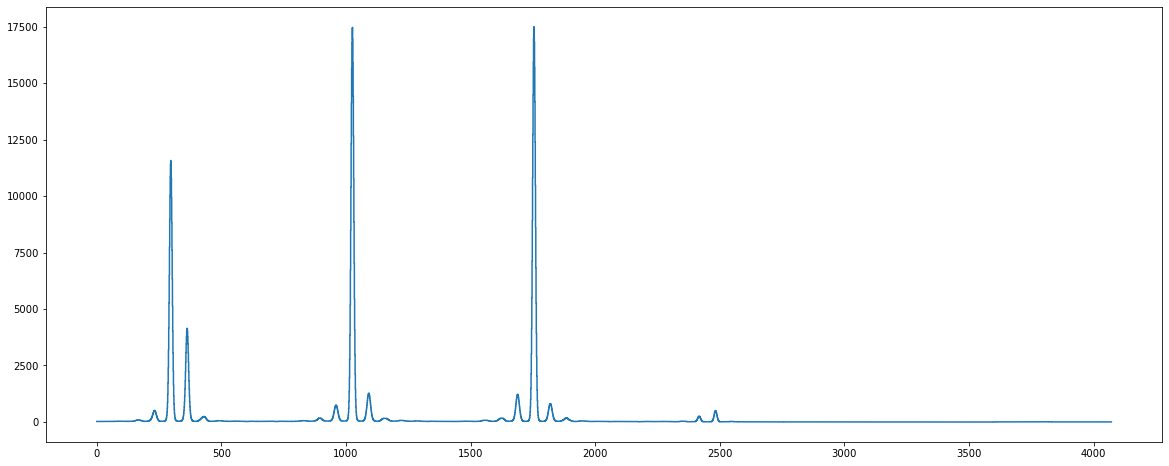

In [4]:
plt.figure(figsize=(20,8))
from scipy.ndimage import gaussian_filter
plt.plot(gaussian_filter(image[1000,:], 5), drawstyle='steps-mid')
#plt.yscale('log')